In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from heapq import nsmallest, nlargest
import seaborn as sns
from pandas import DataFrame
import sys # Prevents errors in some facetgrid calls
from mpl_toolkits.mplot3d import Axes3D

from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, MaxPooling2D, Reshape, LSTM
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.backend import clear_session
from keras.preprocessing.image import ImageDataGenerator
from kerastuner.tuners import RandomSearch

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras import layers

import tensorflow as tf
print(f"Number of GPUs available : {len(tf.config.experimental.list_physical_devices('GPU'))} ")

Number of GPUs available : 1 


In [2]:
# https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients
dataframe = pd.read_csv('default of credit card clients.csv', encoding="utf-8", header=1)
df = dataframe.copy(deep=True) # Make a deep copy so as not to modify the origional dataset
print(df.shape)

(30000, 25)


# Data exploration

## 1) Basic exploration

In [3]:
df.iloc[:,0:12].describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000


In [4]:
df.iloc[:,12:].describe()

,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [5]:
df.head(10)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
5,6,50000,1,1,2,37,0,0,0,0,...,19394,19619,20024,2500,1815,657,1000,1000,800,0
6,7,500000,1,1,2,29,0,0,0,0,...,542653,483003,473944,55000,40000,38000,20239,13750,13770,0
7,8,100000,2,2,2,23,0,-1,-1,0,...,221,-159,567,380,601,0,581,1687,1542,0
8,9,140000,2,3,1,28,0,0,2,0,...,12211,11793,3719,3329,0,432,1000,1000,1000,0
9,10,20000,1,3,2,35,-2,-2,-2,-2,...,0,13007,13912,0,0,0,13007,1122,0,0


In [6]:
total_nans=0
for i in range(0,df.shape[1]):
    total_nans += len(df) - df.iloc[:,i].count()
print(f'The total number of NaNs in the dataset is : {total_nans}')

The total number of NaNs in the dataset is : 0


### Make sure education and marriage values for dataframe are consistent

i.e. all values that do not fit into a category on the dataset description fall into the "other" category.

In [7]:
df['EDUCATION'].loc[(df['EDUCATION'] > 4)] = 4
df['EDUCATION'].loc[(df['EDUCATION'] == 0)] = 4

print(df.iloc[:,3].value_counts())

2    14030
1    10585
3     4917
4      468
Name: EDUCATION, dtype: int64


In [8]:
df['MARRIAGE'].loc[(df['MARRIAGE'] >2)] = 3
df['MARRIAGE'].loc[(df['MARRIAGE'] ==0)] = 3
print(df.iloc[:,4].value_counts())

2    15964
1    13659
3      377
Name: MARRIAGE, dtype: int64


## 2) Understanding each column
It may seem overly time consuming to scan each column since we have 24 features, however the columns can be grouped into 8 'categories', since many of the columns are a values for contiguous points in time (ex: PAY_0 to PAY6 is the History of past payment for 6 consecutive months).

Therefore it is worth examining how each factor affects the chance of a credit card default in order to better understand how important each feature is in determining the outcome of our prediction.

In [9]:
# Define some helper functions

def createbarchart(x,y,title):
    plt.barh(x, y)
    plt.title(title)
    plt.xlabel('Frequency')
    plt.ylabel('Difference in number of rings')
    for index, value in enumerate(y):
        plt.text(value, index, str(value))

def createpiechart(sizes, labels, colors, titles):
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, colors=colors, labels=labels, autopct='%1.1f%%', startangle=90)
    blank = plt.Circle((0,0),0.70,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(blank)
    ax1.axis('equal')  
    plt.tight_layout()
    ax1.set_title(titles)
    plt.show()
    
def accumulateColumns(a, colname): # Returns a dataframe consisting of the sum of columns as 1 column, and the target column
    row_sum = []
    for _,row in a.iterrows():
        row_sum.append(sum(row))
    col = DataFrame(row_sum,columns=[colname])
    df2 = pd.concat([col,b], axis=1)
    return df2

def logSumFacets(a,coltitle):
    for i in range(a.columns.size):
        rows = [] # Each element is sum (log(sum x))
        for x in a.iloc[:,i]: # Sum all the columns for each row, each apply log to each element.        
            if x>0:
                rows.append(np.log1p(x))
            elif x<0:
                rows.append(-(np.log1p(-x)))
            else:
                rows.append(0)
        col = DataFrame(rows,columns=[coltitle+str(i)])
        df2 = pd.concat([col,b], axis=1)
        sns.FacetGrid(df2, hue='default payment next month', height=6, aspect=2).map(sns.kdeplot, coltitle+str(i)).add_legend() 

def accumulateLogSum(a,colname):
    row_sum = [] # Each element is sum (log(sum x))
    for _,row in a.iterrows(): # Sum all the columns for each row, each apply log to each element.
        row_s = 0
        for x in row:
            if x>0:
                row_s += np.log1p(x)
            elif x<0:
                row_s += -(np.log1p(-x))
            else:
                row_s += 0
        row_sum.append(row_s)
    col = DataFrame(row_sum,columns=[colname])
    df2 = pd.concat([col,b], axis=1)
    return df2

def accumulateLogSum_noTarget(a,colname):
    row_sum = [] # Each element is sum (log(sum x))
    for _,row in a.iterrows(): # Sum all the columns for each row, each apply log to each element.
        row_s = 0
        for x in row:
            if x>0:
                row_s += np.log1p(x)
            elif x<0:
                row_s += -(np.log1p(-x))
            else:
                row_s += 0
        row_sum.append(row_s)
    col = DataFrame(row_sum,columns=[colname])
    return col

### Target column: default payment next month

Will the customer in question have a default payment next month based on their financial data?

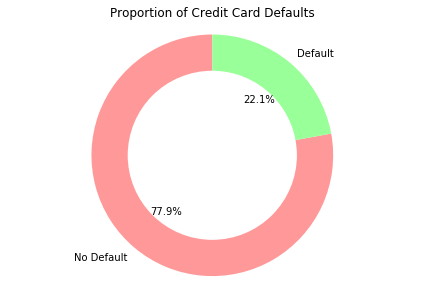

Total number of people who will default: 6636
Total number of people who will default: 23364


In [10]:
col = df.iloc[:,-1]
labels = ['No Default', 'Default']
sizes = [_ for _ in col.value_counts()]
colors = ['#ff9999','#99ff99']
title = 'Proportion of Credit Card Defaults'
createpiechart(sizes, labels, colors, title)


print(f'Total number of people who will default: {sizes[1]}')
print(f'Total number of people who will default: {sizes[0]}')

### First feature: LIMIT_BAL
##### default=1 means credit card default next month.
This feature is the amount of given credit for an individual and their families' credit if applicable.

We can see from the following 2 charts, that individuals with a lower amount of credit have a higher tendancy to default up until around 11000 credit, afterwhich those with a higher credit tend to dault more often.

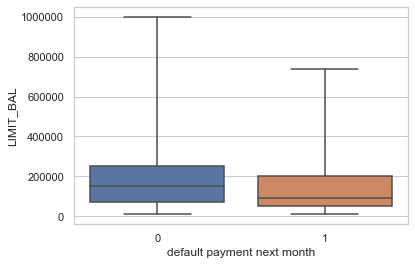

In [11]:
sns.set(style="whitegrid")
ax = sns.boxplot(x="default payment next month", y="LIMIT_BAL", data=df, whis=np.inf)

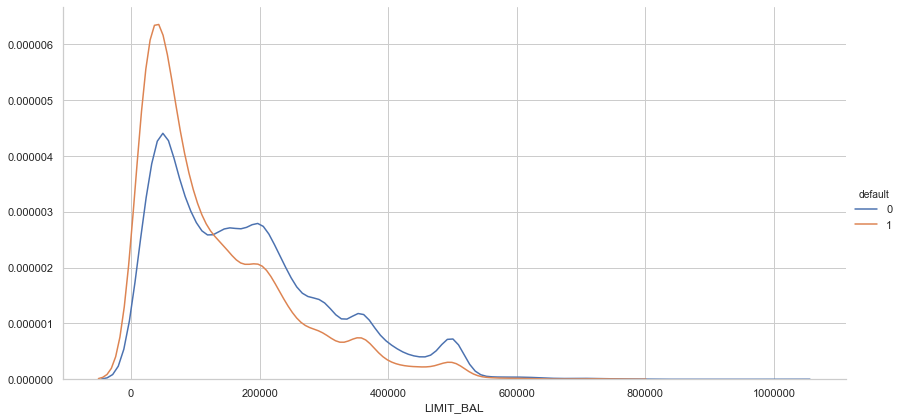

In [12]:
a = df.iloc[:, 1]
b = df.iloc[:, -1]
df1 = pd.DataFrame({'default':b, 'LIMIT_BAL':a})
sns.FacetGrid(df1, hue="default", height=6, aspect=2).map(sns.kdeplot, 'LIMIT_BAL').add_legend()

### Second feature: SEX

Are men or women more likely to default? According to this dataset, men are slightly more likely.

Since there are a lot more women than men in the dataset (18112 women, 11888 men, 6224 difference), it might make more sense to try to calculate the probability in the following direction: If a credit card defaults, what is the most likely gender of the owner of said card?

More formally: Let Ai be a partition of the sample space of individuals in the study. We partition the sample space into gender, namely A1=male, A2=female. Let B be the set of individuals who will default their credit card next month. Then for i=1,2

$P(gender|default) = P(Ai|B) = \frac{P(B|Ai) * P(Ai)}{\sum_{j=1}^{inf} P(B|Aj)P(Aj)}$ , (but since A1 and A2 are complements we consider just P(B) in the denominator and subtract from 1 for the complement event).

We will say P(B|Ai) is the empirical probability of defaulting given the gender, i.e. the proportion of defaults for a certain gender.

Note that the result is simply the proportion of male or female out of the total number of credit card defaults, which isn't very meaningful.

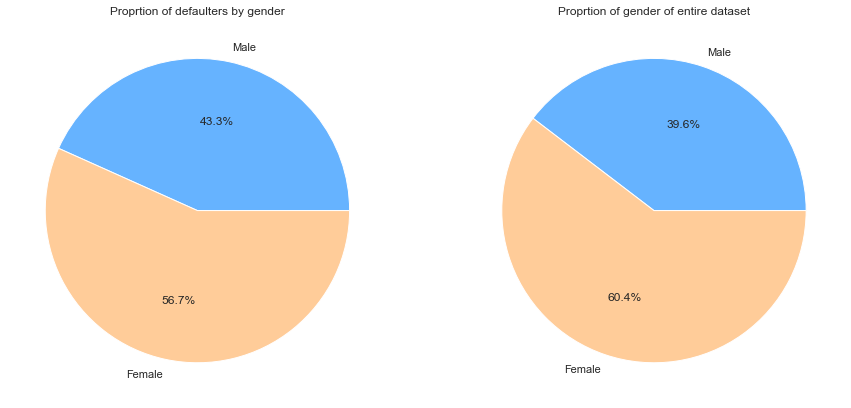

In [13]:
# Total proprtions
m,w = sum(df['SEX']==1), sum(df['SEX']==2)
total_mw = m+w

# Defaulting proportions
m_def,w_def = sum((df['SEX']==1) & df['default payment next month']==1),sum((df['SEX']==2) & df['default payment next month']==1)
total_defaulters = m_def+w_def

# Probabilities
pa1 = m/total_mw # Probability of male
pa2 = w/total_mw # Probability of female
pb = total_defaulters/total_mw # Empirical probability of defaulting
pba1 = m_def/m # Proportion of male defaulters amongst male
pba2 = w_def/w # Proportion of female defaulters amongst female
pa1b,pa2b = (pba1*pa1)/(pba1*pa1 + pba2*pa2),(pba2*pa2)/(pba1*pa1 + pba2*pa2)

fig, axs = plt.subplots(1, 2, figsize=(15,15))
axs[0].pie([100*pa1b, 100*pa2b], labels=['Male', 'Female'], colors=['#66b3ff','#ffcc99'], autopct='%1.1f%%')
axs[0].set_title('Proprtion of defaulters by gender')
axs[1].pie([m, w], labels=['Male', 'Female'], colors=['#66b3ff','#ffcc99'], autopct='%1.1f%%')
axs[1].set_title('Proprtion of gender of entire dataset')
plt.show()

This isn't very meaningful, since the proportion of credit card defaults is skewed by the higher number of female, however the above charts might suggest that men are more likely to default. So what if we switch the sample space from gender to default or not? 
##### This proves that men are 4% more likely to default.

Let Ai be a partition of the sample space of defaults in the study. We partition the sample space as follows: A1=default, A2=no default. Let B be the set of all individuals of a certain gender. Then for i=1,2

$P(Ai|B) = \frac{P(B|Ai) * P(Ai)}{\sum_{j=1}^{inf} P(B|Aj)P(Aj)}$.

However we only really care about defaulting, so we simply calculate:

$P(default|gender) = \frac{P(gender|default) * P(default)}{P(gender)}$ , where P(gender|default) is what we found above.

##### From now on, we will consider the set B to be the set of all individuals that fit within a certain feature, and the sample space Ai will be individuals who default.

Probability of defaulting given the card owner is male : 24.17%
Probability of defaulting given the card owner is female :  20.78%


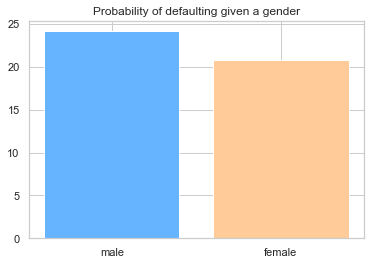

In [14]:
m,w = sum(df['SEX']==1), sum(df['SEX']==2)
total_mw = m+w
default,no_default = sum(df['default payment next month']==1), sum(df['default payment next month']==0)
total = default+no_default
pmale,pfemale = m/total_mw,  w/total_mw
pdefault = default/total
pdmale = (pa1b*pdefault)/pmale
pdfemale = (pa2b*pdefault)/pfemale

x,y =['male','female'],[100*pdmale,100*pdfemale]
fig, ax = plt.subplots()
ax.set_title('Probability of defaulting given a gender')
ax.bar(x,y, color=('#66b3ff','#ffcc99'))
print(f'Probability of defaulting given the card owner is male : {100*pdmale:.2f}%')
print(f'Probability of defaulting given the card owner is female :  {100*pdfemale:.2f}%')

### Third feature: EDUCATION

We can apply the same Bayesian logic to education as we did for gender.

$P(default|education) = \frac{P(education|default) * P(default)}{P(education)}$ , where the prior is the empirical probability of a cardholder's education given a default.

The results of this section shows that lower education level individuals have a higher chance of defaulting. High school education individuals have a 25.16% of defaulting, 23.73% for university level education and 19.23% for grad school. Due to limitted explanation of what the 'other' categories which have a 7.05% of defaulting, we omit an explanation.

Sum of grad school and default : 2036
Sum of uni and default: 3330
Sum of highschool and default: 1237
Sum of other and default: 33
sum: 6636

probability of grad school: 0.35
probability of uni: 0.47
probability of highschool: 0.16
probability of other: 0.02
sum: 1.00

proportion of grad school defaulters to all defaulters: 0.31
proportion of uni defaulters to all defaulters: 0.50
proportion of highschool defaulters to all defaulters: 0.19
proportion of other defaulters to all defaulters: 0.0050
sum: 1.00

Posterior probabilities:
Probability of defaulting given grad school level education: 19.23%
Probability of defaulting given university level education : 23.73%
Probability of defaulting given highschool level education : 25.16%
Probability of defaulting given other education levels: 7.05%


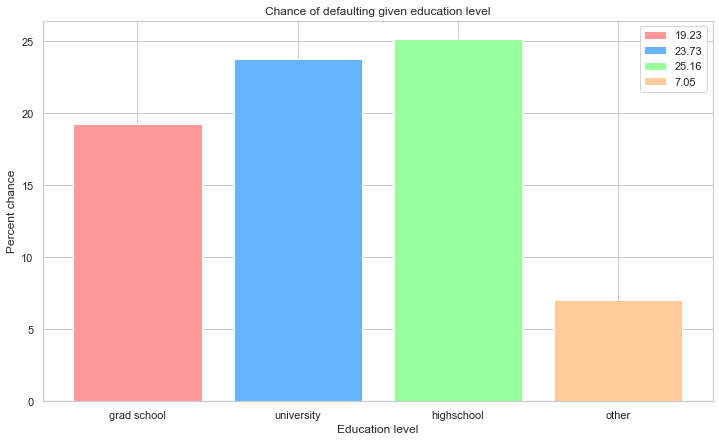

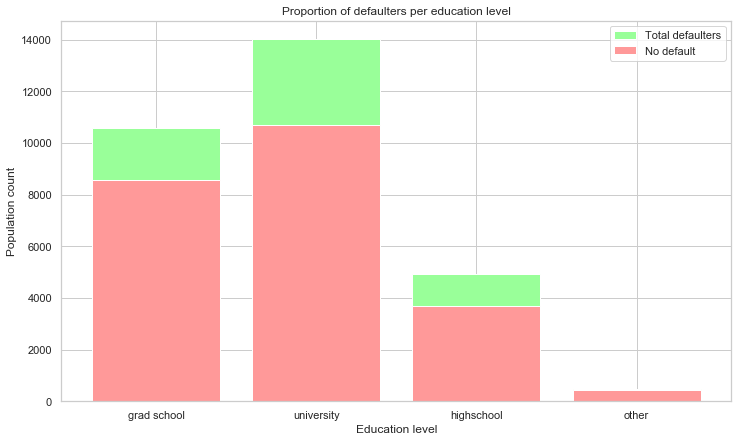

In [16]:
counts = df.iloc[:,3].value_counts()
d = {'grad school':counts[1], 'university':counts[2], 'highschool':counts[3], 'other':counts[4]}

total = (sum(d.values()))
defs = sum(df['default payment next month']==1)
p_default = defs/total

# Default count for each education level
grad_def = sum((df['EDUCATION']==1) & df['default payment next month']==1)
uni_def = sum((df['EDUCATION']==2) & df['default payment next month']==1)
high_def = sum((df['EDUCATION']==3) & df['default payment next month']==1)
other_def = sum(df['default payment next month']==1) - (grad_def+uni_def+high_def)
print(f'Sum of grad school and default : {grad_def}')
print(f'Sum of uni and default: {uni_def}')
print(f'Sum of highschool and default: {high_def}')
print(f'Sum of other and default: {other_def}')
print(f'sum: {grad_def+uni_def+high_def+other_def}\n')

# Probability of each education level
p_grad,p_uni,p_high,p_other = d.get('grad school')/total,d.get('university')/total,d.get('highschool')/total,d.get('other')/total
print(f'probability of grad school: {p_grad:.2f}')
print(f'probability of uni: {p_uni:.2f}')
print(f'probability of highschool: {p_high:.2f}')
print(f'probability of other: {p_other:.2f}')
print(f'sum: {p_grad+p_uni+p_high+p_other:.2f}\n')

# Prior
p_grad_def,p_uni_def,p_high_def,p_other_def = grad_def/defs, uni_def/defs, high_def/defs, other_def/defs
print(f'proportion of grad school defaulters to all defaulters: {p_grad_def:.2f}')
print(f'proportion of uni defaulters to all defaulters: {p_uni_def:.2f}')
print(f'proportion of highschool defaulters to all defaulters: {p_high_def:.2f}')
print(f'proportion of other defaulters to all defaulters: {p_other_def:.4f}')
print(f'sum: {p_grad_def+p_uni_def+p_high_def+p_other_def:.2f}\n')

# Posterior
p_def_grad,p_def_uni,p_def_high,p_def_other = (p_grad_def*p_default)/p_grad,(p_uni_def*p_default)/p_uni,(p_high_def*p_default)/p_high, (p_other_def*p_default)/p_other
print('Posterior probabilities:')
print(f'Probability of defaulting given grad school level education: {100*p_def_grad:.2f}%')
print(f'Probability of defaulting given university level education : {100*p_def_uni:.2f}%')
print(f'Probability of defaulting given highschool level education : {100*p_def_high:.2f}%')
print(f'Probability of defaulting given other education levels: {100*p_def_other:.2f}%')

plt.figure(figsize=[12, 7])
sizes = [p_def_grad,p_def_uni,p_def_high,p_def_other]
sizes = [i*100 for i in sizes]
levels = [_ for _ in d.keys()]
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
for i in range(len(sizes)):
    plt.bar(levels[i], sizes[i], color=colors[i])
plt.legend(labels = [str(round(i, 2)) for i in sizes])
plt.title('Chance of defaulting given education level')
plt.xlabel('Education level')
plt.ylabel('Percent chance')
plt.show()

plt.figure(figsize=[12, 7])
levels = [_ for _ in d.keys()]
total = [_ for _ in d.values()]
defaulters = [grad_def,uni_def,high_def,other_def]
for i in range(len(total)):
    plt.bar(levels[i], defaulters[i], bottom=total[i]- defaulters[i], color='#99ff99')
    plt.bar(levels[i], total[i] - defaulters[i], color='#ff9999')

plt.legend(labels = ['Total defaulters','No default'])
plt.title("Proportion of defaulters per education level")
plt.xlabel('Education level')
plt.ylabel('Population count')
plt.show()

### Fourth feature: MARRIAGE

Using the same method as above, we can observe that there is less discrepency between differing marital statuses on the effect of defaulting, however it is worth noting that married individuals have a slightly higher chance of defaulting (23.47% versus 20.93%)

Sum of married and default : 3206
Sum of single and default: 3341
Sum of other and default: 89
probability of marriage: 0.35
probability of single: 0.47
probability of other: 0.01
proportion of married defaulters to all defaulters: 0.31
proportion of single defaulters to all defaulters: 0.50
proportion of other defaulters to all defaulters: 0.0134
Posterior probabilities:
Probability of defaulting given an individual is married: 23.47%
Probability of defaulting given an individual is single : 20.93%
Probability of defaulting given other marrital status: 23.61%


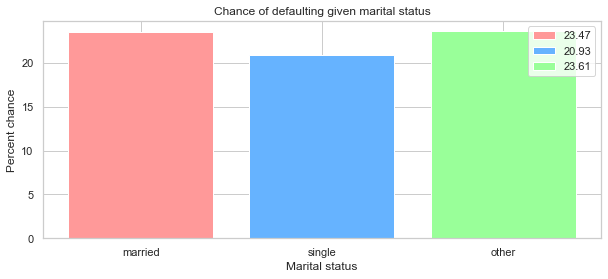

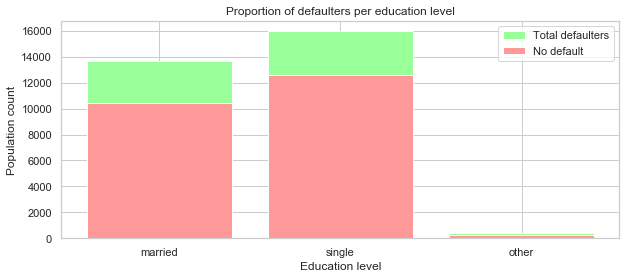

In [17]:
counts = df.iloc[:,4].value_counts()
d = {'married': counts[1], 'single':counts[2], 'other':counts[3]}

total = (sum(d.values()))
defs = sum(df['default payment next month']==1)
p_default = defs/total

# Default count for each marriage level
married_def = sum((df['MARRIAGE']==1) & df['default payment next month']==1)
single_def = sum((df['MARRIAGE']==2) & df['default payment next month']==1)
other_def = sum(((df['MARRIAGE']==3) | (df['MARRIAGE']==0)) & df['default payment next month']==1)
print(f'Sum of married and default : {married_def}')
print(f'Sum of single and default: {single_def}')
print(f'Sum of other and default: {other_def}')

# Probability of each marriage level
p_married,p_single,p_other = d.get('married')/total,d.get('single')/total,d.get('other')/total
print(f'probability of marriage: {p_grad:.2f}')
print(f'probability of single: {p_uni:.2f}')
print(f'probability of other: {p_other:.2f}')

# Prior
p_married_def,p_single_def,p_other_def = married_def/defs, single_def/defs, other_def/defs
print(f'proportion of married defaulters to all defaulters: {p_grad_def:.2f}')
print(f'proportion of single defaulters to all defaulters: {p_uni_def:.2f}')
print(f'proportion of other defaulters to all defaulters: {p_other_def:.4f}')

# Posterior
p_def_married = (p_married_def*p_default)/p_married
p_def_single = (p_single_def*p_default)/p_single
p_def_other = (p_other_def*p_default)/p_other
print('Posterior probabilities:')
print(f'Probability of defaulting given an individual is married: {100*p_def_married:.2f}%')
print(f'Probability of defaulting given an individual is single : {100*p_def_single:.2f}%')
print(f'Probability of defaulting given other marrital status: {100*p_def_other:.2f}%')

plt.figure(figsize=[10, 4])
sizes = [p_def_married,p_def_single,p_def_other]
sizes = [i*100 for i in sizes]
levels = [_ for _ in d.keys()]
colors = ['#ff9999','#66b3ff','#99ff99']
for i in range(len(sizes)):
    plt.bar(levels[i], sizes[i], color=colors[i])
plt.legend(labels = [str(round(i, 2)) for i in sizes])
plt.title('Chance of defaulting given marital status')
plt.xlabel('Marital status')
plt.ylabel('Percent chance')
plt.show()

plt.figure(figsize=[10, 4])
levels = [_ for _ in d.keys()]
total = [_ for _ in d.values()]
defaulters = [married_def,single_def,other_def]
for i in range(len(total)):
    plt.bar(levels[i], defaulters[i], bottom=total[i]- defaulters[i], color='#99ff99')
    plt.bar(levels[i], total[i] - defaulters[i], color='#ff9999')

plt.legend(labels = ['Total defaulters','No default'])
plt.title("Proportion of defaulters per education level")
plt.xlabel('Education level')
plt.ylabel('Population count')
plt.show()

### Fifth feature: AGE

Individuals which are between the age of roughly 25-40 are less likely to default, which is the age in which individuals most likely to be in the earlier stages of their careers. Younger individuals are more likely to default, likely due to having lower income and/or less financial savy. Older individuals have a higher chance of defaulting as well.

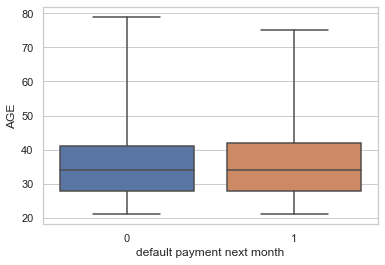

In [18]:
sns.set(style="whitegrid")
ax = sns.boxplot(x="default payment next month", y="AGE", data=df, whis=np.inf)

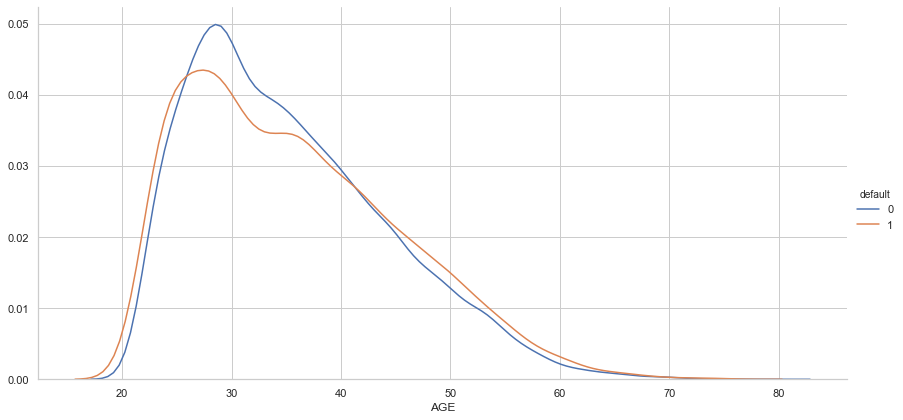

In [19]:
a = df.iloc[:, 5]
b = df.iloc[:, -1]
df1 = pd.DataFrame({'default':b, 'AGE':a})
sns.FacetGrid(df1, hue="default", height=6, aspect=2).map(sns.kdeplot, 'AGE').add_legend()

### Sixth feature: History of past payment

##### Although no correlation calculation has been made so far, I predict there is a strong correlation between these columns and defaulting.

These columns tracks the past monthly payment record for consecutive months. Each column is an indexer for the payment for 6 months for an individual. For example, PAY_0 is the repayment status in September 2005, PAY_1 is the repayment status in August 2005 etc... 

The value for the payment scale is as follows: " -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; "

If we look at the Facetgrid for each column, we observe that individuals who pay duly or earlier are much less likely to default next month. More notably, individuals who paid duly in the 'earlier' columns (PAY_0, PAY_1) etc... are much less likely to default. In PAY_5, the proportion of those who pay duly and do not default next month, and those who do default next month is much closer than in PAY_0.

If we look at the sum of payment histories, we get a more clear picture (note, using average yields the same results as sum). Individuals who pay duly (0) are much less likely to default. Individuals who pay late are much more likely to default. Individuals who pay early are typically less likely to default, however it's not so clear cut.

##### This could indicate that individuals who have automatic payment set up, or are extremely consistent with paying on time are much less likely to default.

In [20]:
a = df.iloc[:, 6:11]
b = df.iloc[:, -1]
df1 = pd.concat([a,b], axis=1)

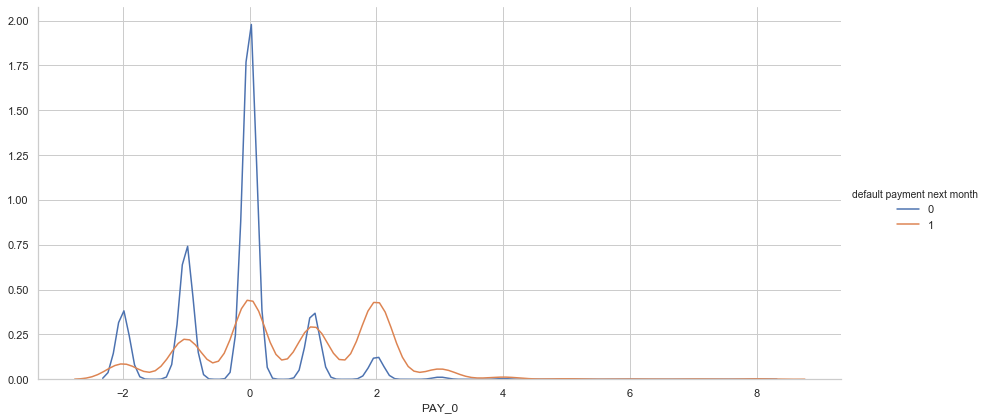

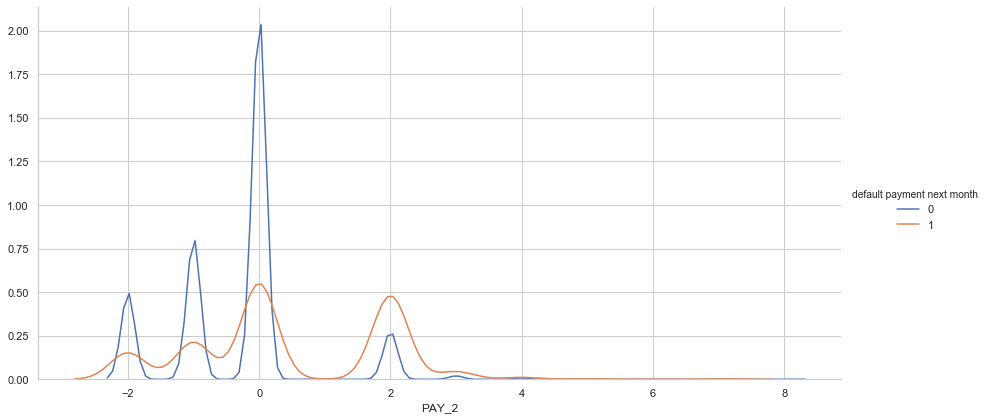

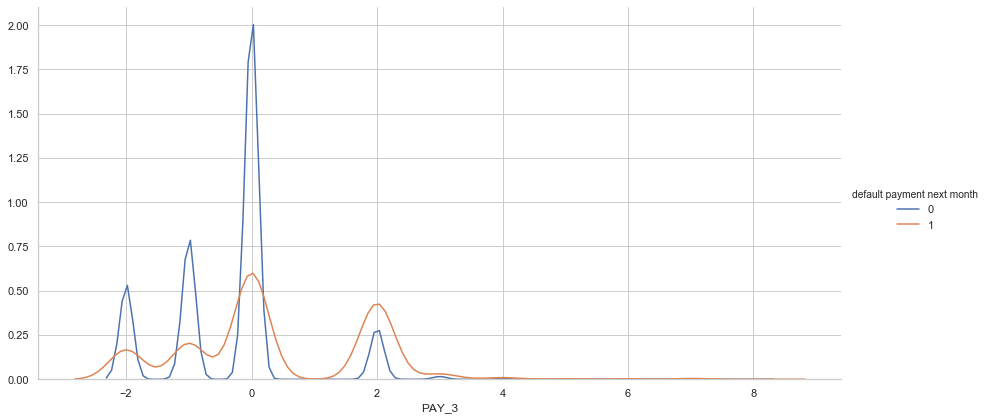

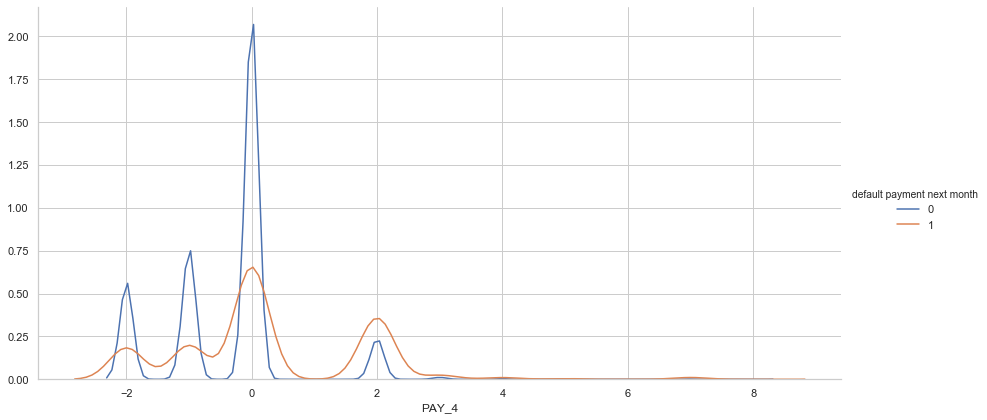

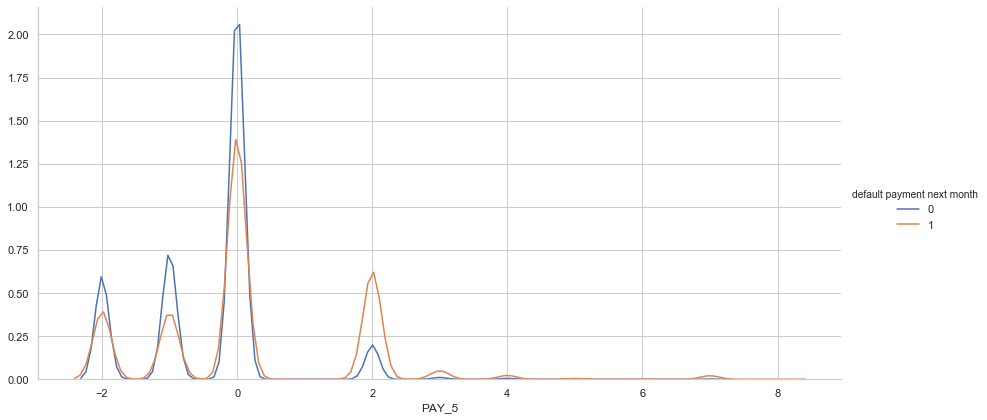

In [21]:
for i in range(6):
    if i!=1: # Column PAY_1 doesn't exist in dataset
        sns.FacetGrid(df1, hue='default payment next month', height=6, aspect=2).map(sns.kdeplot, 'PAY_'+str(i)).add_legend()

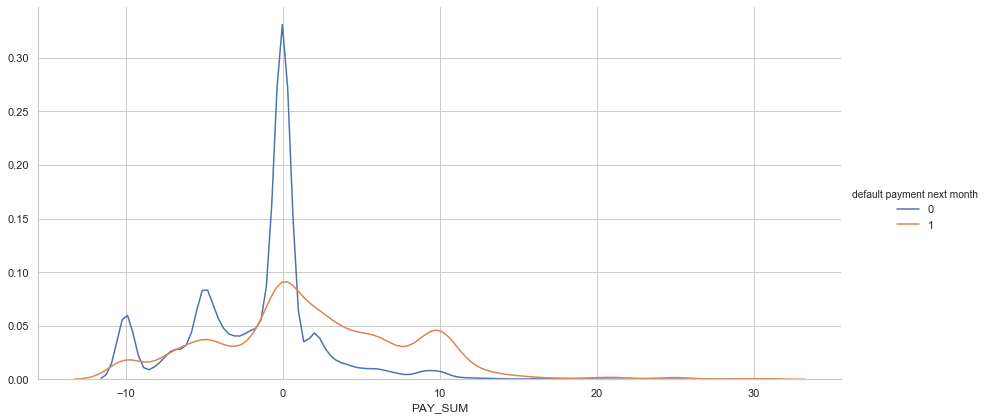

In [22]:
df_pay_sum = accumulateColumns(a,'PAY_SUM')
sns.FacetGrid(df_pay_sum,hue='default payment next month', height=6, aspect=2).map(sns.kdeplot, 'PAY_SUM').add_legend()

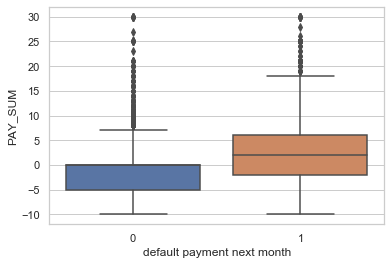

In [23]:
ax = sns.boxplot(x="default payment next month", y="PAY_SUM", data=df_pay_sum)

### Seventh feature: Amount of bill statement

The first column, BILL_AMT, is an individuals' bill statement amount on September 2005, the second column BILL_AMT2 is the individual's bill statement on August 2005, etc...

It is difficult to draw any immediate conclusions from these columns, or even the log of the amount billed amount. Looking at each individual column, it seems that individuals with a billing amount of 0 tend to default less, but if we look at the log-scaled sum for the columns (summed into 1 column), we can see that this is not necessarily the case. 

It appears the individuals with a high bill sum which increases over time, or a bill sum of 0 are more prone to defaulting.

Text(0.5, 0.98, 'Facetgrid of BILL_AMT1 of defaulters and non-defaulters.')

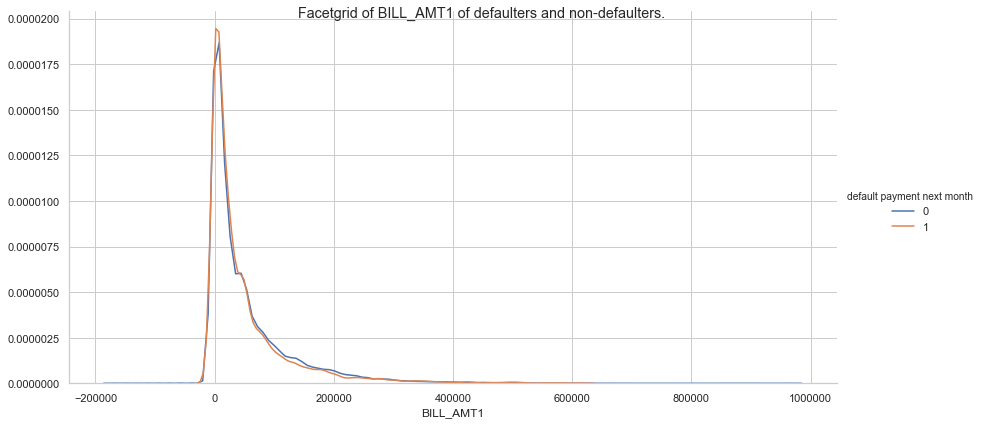

In [24]:
a = df.iloc[:, 12:18]
b = df.iloc[:, -1]
df1 = pd.concat([a,b], axis=1)
sns.FacetGrid(
    df1, 
    hue='default payment next month', 
    height=6, 
    aspect=2).map(sns.kdeplot, 'BILL_AMT1').add_legend().fig.suptitle('Facetgrid of BILL_AMT1 of defaulters and non-defaulters.')
#for i in range(1,7):
    #sns.FacetGrid(df1, hue='default payment next month', height=6, aspect=2).map(sns.kdeplot, 'BILL_AMT'+str(i)).add_legend()

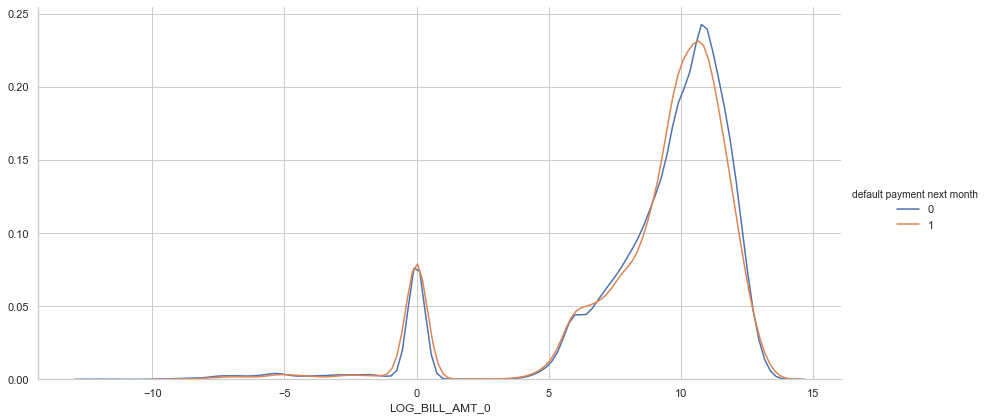

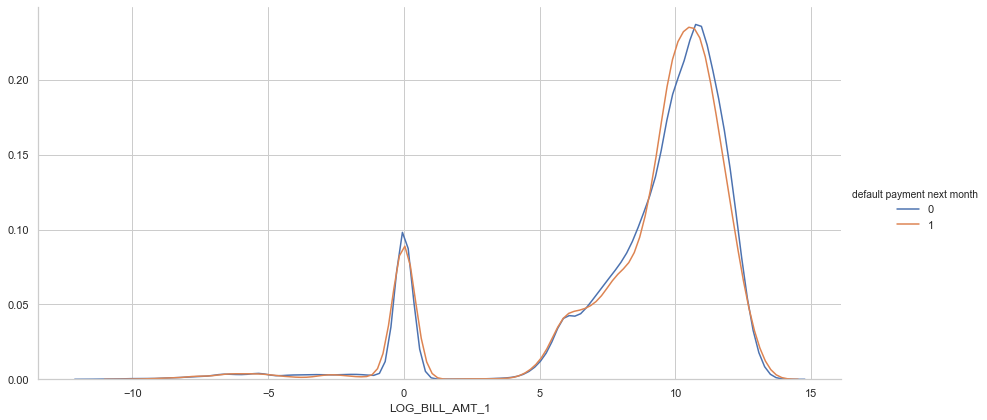

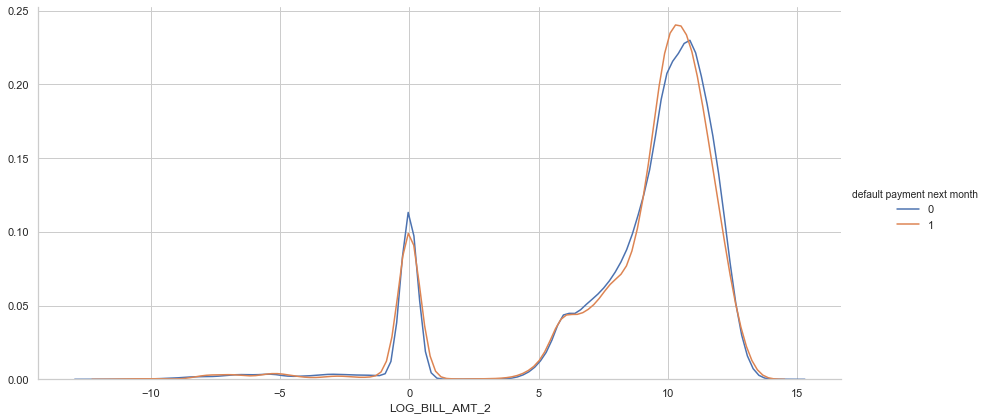

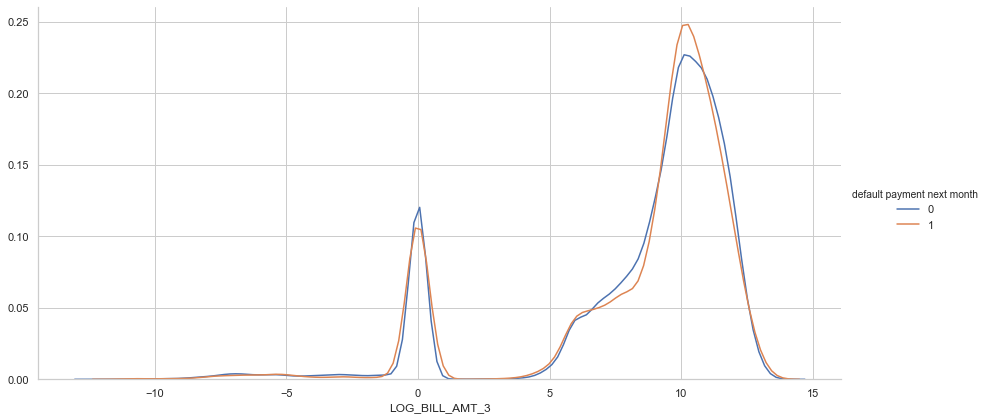

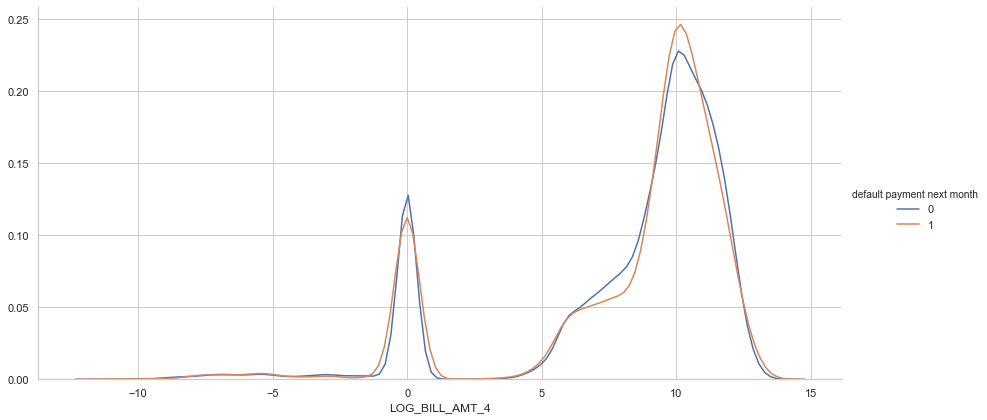

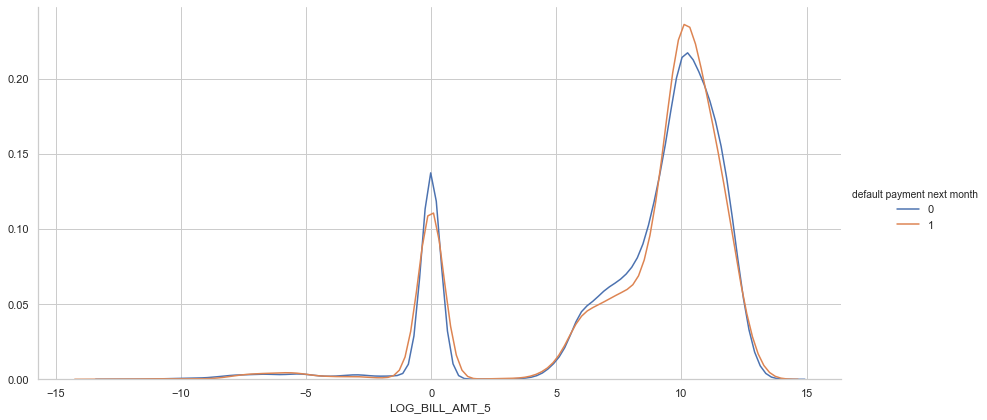

In [25]:
logSumFacets(a,'LOG_BILL_AMT_')

#### Observation: for consecutive increasing time periods, if the bill sum remains high, the chance of defaulting next month.

This observation provides motivation to add a new feature: log sum of the bills.

Consider an individual represented by a row in the dataframe. Each row has 5 columns, BILL_SUM 0-4. For each element in each column, we will take the log of each element and accumulate the value as a sum. _The resulting sum will be a new feature_. 

We do this by the observation that for the 2nd large spike, where the log(sum bill amount)=10 in the LOG_BILL_AMT facetgrids, the first few columns have the chance of defaulting next month lower than the chance of not defaulting. However as the months progress, the chance of defaulting increases until at LOG_BILL_AMT_2, the chance of defaulting has surpassed the chance of not defaulting. As the months go on, the proportion of individuals with higher bill sums and who default increases compared to the proportion of individuals with lower bill sums but do not default. If you are an individual who log(sum bill amount) ranges between roughly 6 and 9, your chances of defaulting next month actually decrease as the months progress. Furthermore, if your log(sum bill amount) is around 0, your chances of defaulting next month decrease as the months progress.

This is all complex information, however if we observe the log-sum of an individual's bills over the past months, it becomes more clear who is more likely to default. Although the correlation does not appear strong, it could still indicate that this is a potentially important observation.

Text(0.5, 0.98, 'Facetgrid of Log-Sum of Individual Bills')

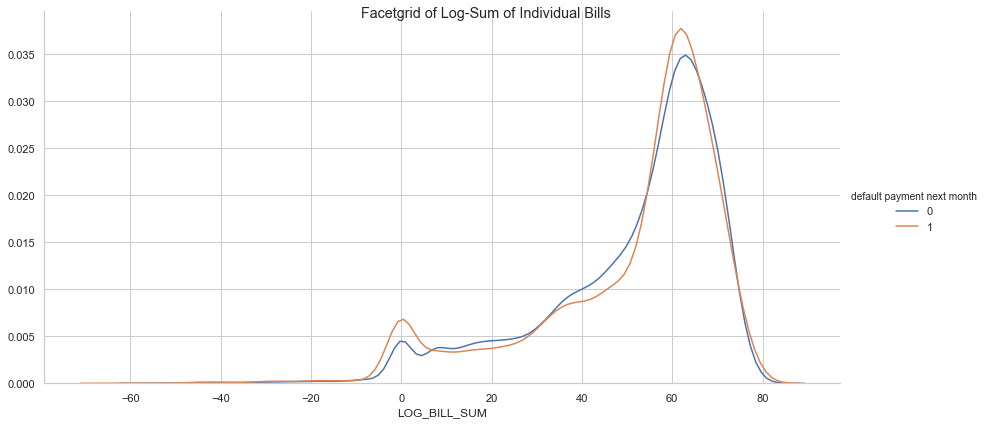

In [26]:
df_log_bill_sum = accumulateLogSum(a,'LOG_BILL_SUM')
sns.FacetGrid(
    df_log_bill_sum, 
    hue='default payment next month', 
    height=6, 
    aspect=2).map(sns.kdeplot, 'LOG_BILL_SUM').add_legend().fig.suptitle('Facetgrid of Log-Sum of Individual Bills')

### Eigth feature: Amount of previous payment

This column consists of the amount the individual has paid on their previous payment. PAY_AMT1 is the amount paid in September 2005, PAY_AMT2 is the amount paid in August 2005 etc...Looking at the facetgrids of the values makes it difficult to draw any conclusions due to the scaling and variance of the values, so to visualise the data better, we take the log of each value and plot the facetgrids as such.

The log of the amount paid at each month is very indicative of whether an individual will default. We see distinct spikes around the log(amount paid) of 0 and 7.5. At these spikes, we see that individuals have a lower chance of defaulting by anywhere between roughly 5% to 20%, depending on the column.

Looking at the log-sum, it is clear that individuals who pay a lower amount over the course of their history have a higher chance of defaulting. 

This could potentially be because individuals who have the ability to pay more of their credit card are less likely to default since they have the capital to do so.

Example chart of PAY_AMT column. All column appear very similar to the figure below.


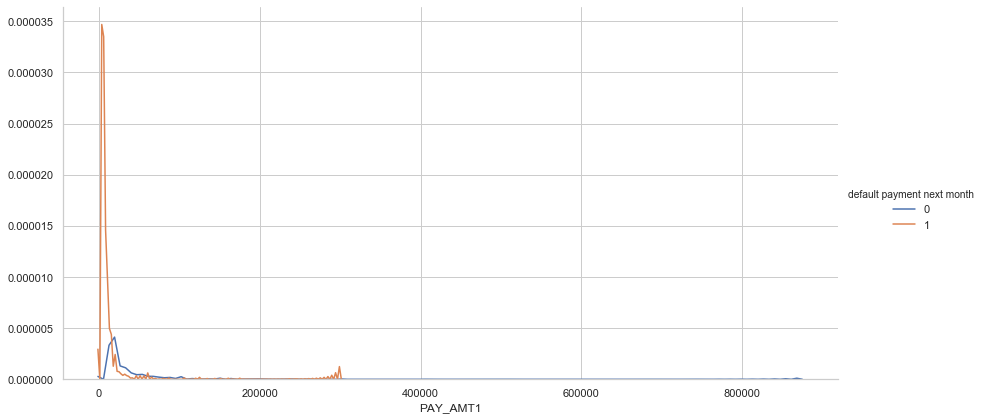

In [27]:
a = df.iloc[:, 18:24]
b = df.iloc[:, -1]
df1 = pd.concat([a,b], axis=1)
print('Example chart of PAY_AMT column. All column appear very similar to the figure below.')
sns.FacetGrid(df1, hue='default payment next month', height=6, aspect=2).map(sns.kdeplot, 'PAY_AMT'+str(1)).add_legend()

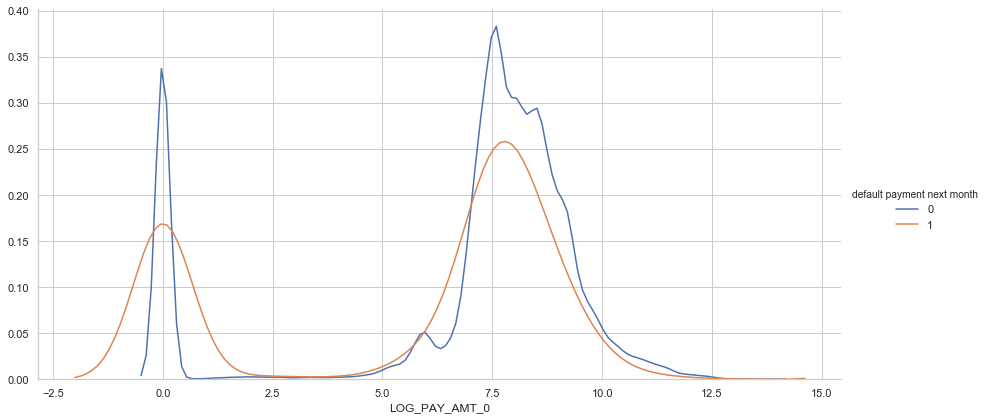

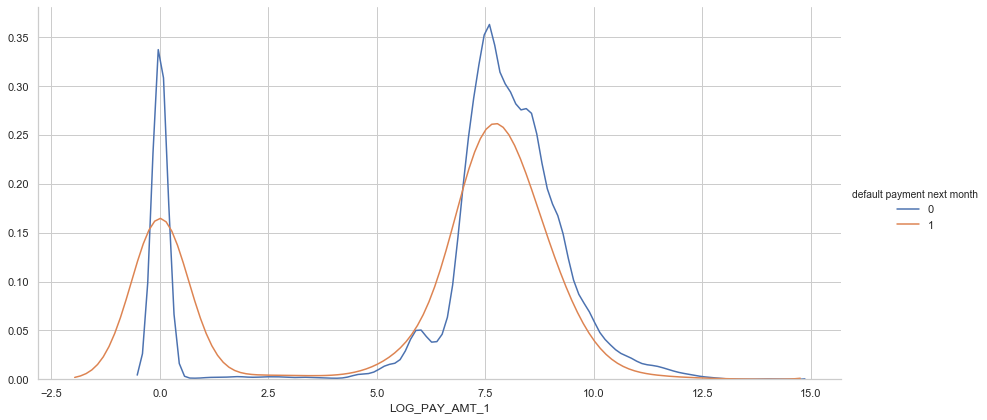

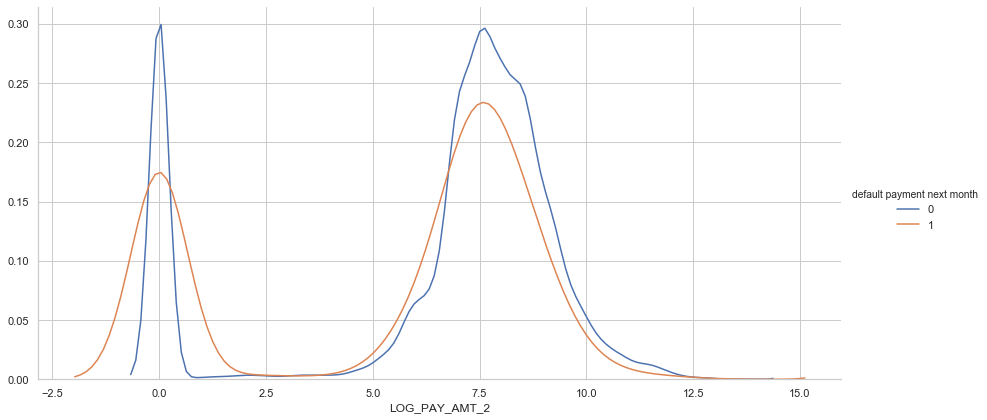

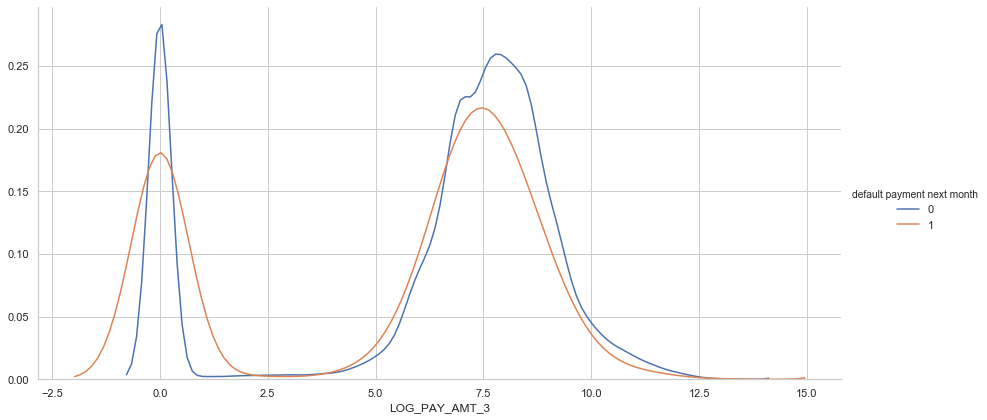

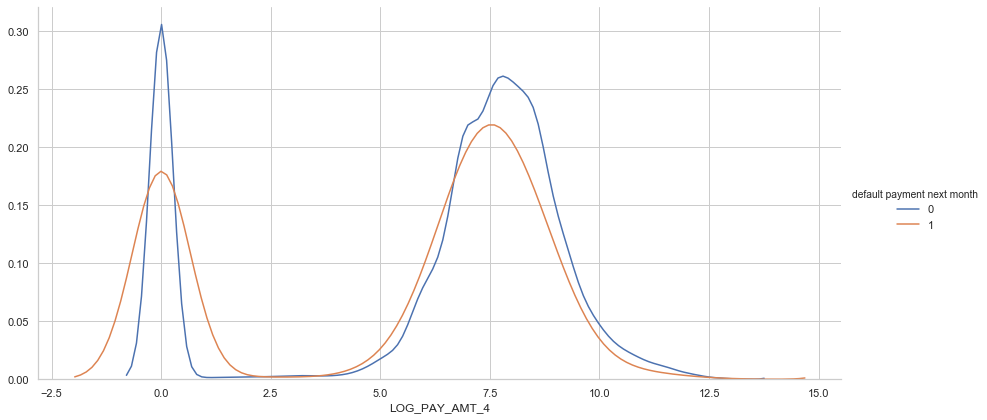

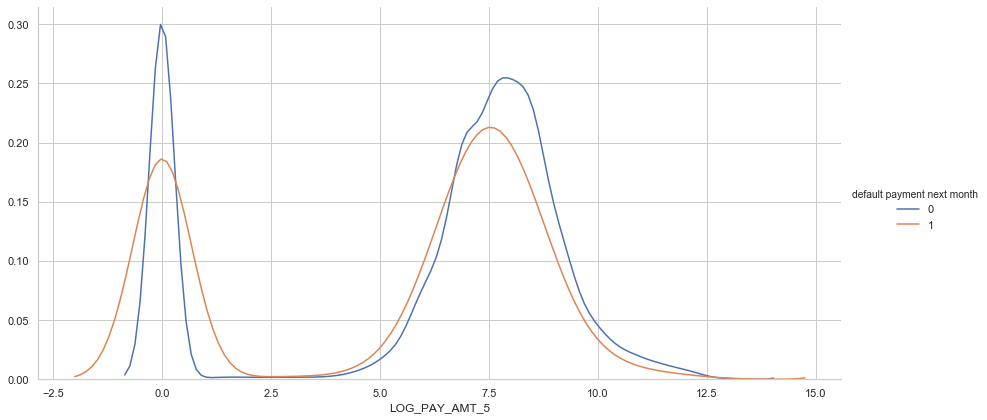

In [28]:
logSumFacets(a,'LOG_PAY_AMT_')

Text(0.5, 0.98, 'Facetgrid of Log-Sum of Individual Bill Payments')

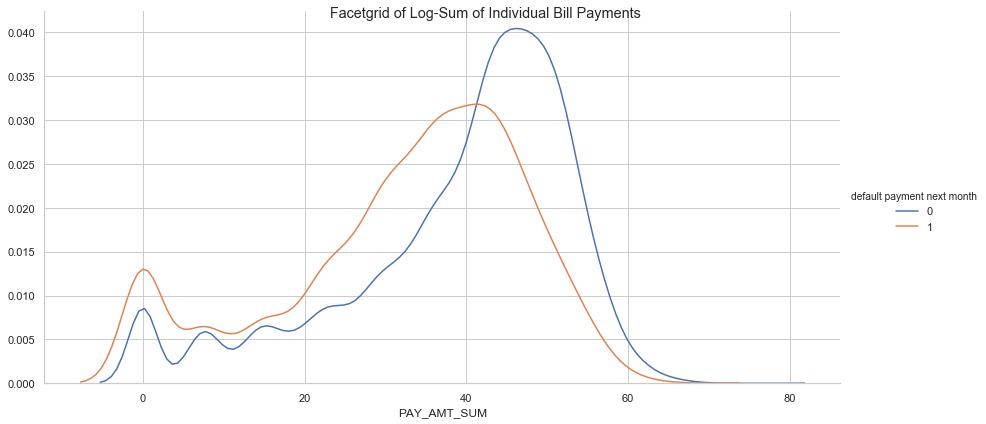

In [29]:
df_log_bill_sum = accumulateLogSum(a,'PAY_AMT_SUM')
sns.FacetGrid(
    df_log_bill_sum, 
    hue='default payment next month', 
    height=6, 
    aspect=2).map(sns.kdeplot, 'PAY_AMT_SUM').add_legend().fig.suptitle('Facetgrid of Log-Sum of Individual Bill Payments')

### 3) Initial thoughts about the data

It is clear that some features have a stronger correlation than others with the chance of defaulting. We also observed that the effect of some features become more clear when we introduce a new feature related to several of the other features. It may therefor be helpful to build a new dataframe based on the current data to train on the model. This dataframe might consist of less features, where each feature is a result of several features combined. This dataframe might also consist of more features, where we keep all the initial data, and add the additional features to the dataframe and simply let the model determine which features are more or less important. For now, we will simply build a bigger dataframe and check the correlation of all features.

In [31]:
pay = df.iloc[:, 6:12]
paydf = accumulateLogSum_noTarget(pay, 'PAY_LOGSUM')

bill = df.iloc[:,12:18]
billdf = accumulateLogSum_noTarget(bill, 'BILL_LOGSUM')

payamt = df.iloc[:, 18:24]
payamtdf = accumulateLogSum_noTarget(payamt, 'PAYAMT_LOGSUM')

target_tmp = df.iloc[:,-1]
firstcols = df.iloc[:,:6]
newdf = pd.concat([firstcols,pay,paydf,bill,billdf,payamt,payamtdf,target_tmp], axis=1)
print(newdf.shape)
newdf.describe()

(30000, 28)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT6,BILL_LOGSUM,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,PAYAMT_LOGSUM,default payment next month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.842267,1.557267,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,38871.760400,51.111974,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,37.518582,0.221200
std,8660.398374,129747.661567,0.489129,0.744494,0.521405,9.217904,1.123802,1.197186,1.196868,1.169139,...,59554.107537,19.948217,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,14.768161,0.415062
min,1.000000,10000.000000,1.000000,1.000000,1.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-339603.000000,-61.729831,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,1256.000000,41.897500,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,30.170963,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,17071.000000,58.222782,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,41.554467,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,49198.250000,64.958383,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,48.194899,0.000000
max,30000.000000,1000000.000000,2.000000,4.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,961664.000000,81.985825,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,76.515991,1.000000


### 4) The data as a whole

We now examine how all the dataset as a whole using various techniques.

#### Starting easy with a correlation matrix

We see that the PAY_i features have the highest correlation to whether or not the individual will default next month. Namely, PAY_0 has the highest correlation value, with 0.32 which the feature we added, PAY_LOGSUM has the second highest correlation value of 0.28. We can also see that another feature we added, BILL_LOGSUM has a relatively high correlation with the PAY_i columns. Unfortunately, no major definitive conclusions can be drawn about predicting credit card defaults from the individual features.

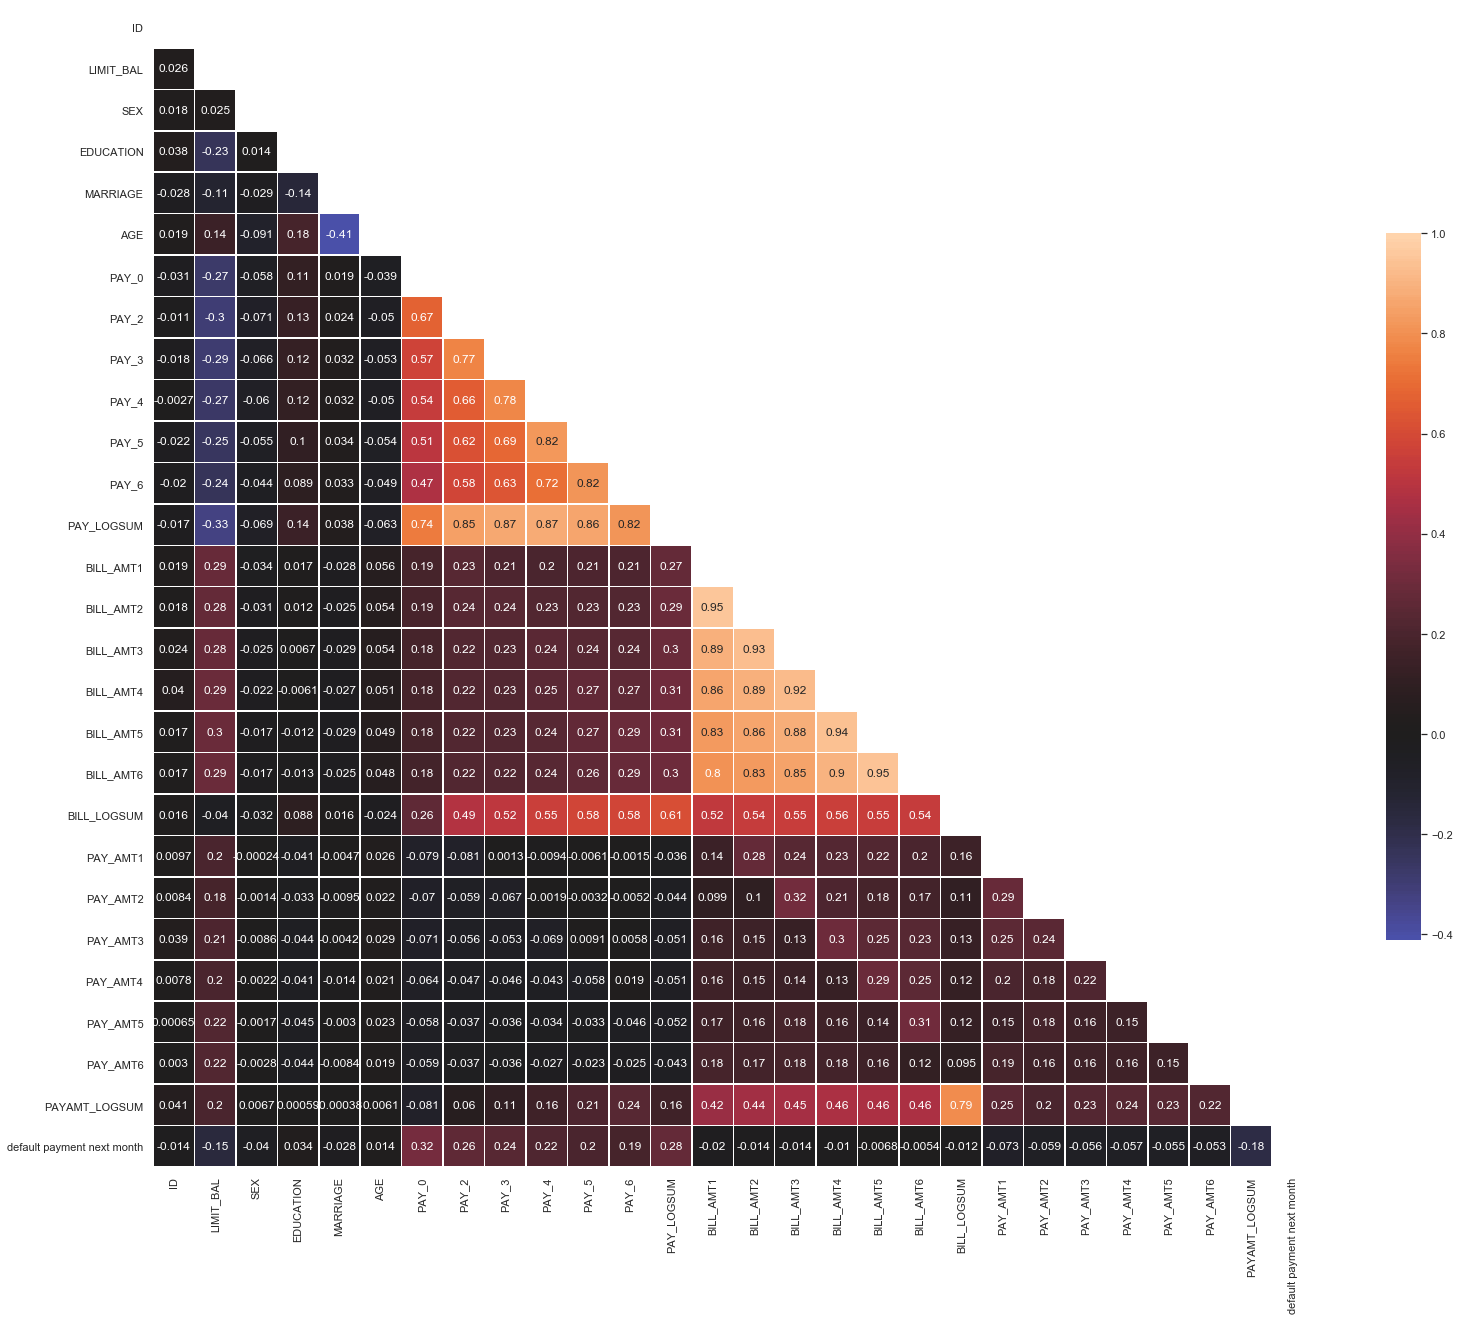

In [32]:
corr = newdf.corr() # Compute the correlation matrix
mask = np.triu(np.ones_like(corr,dtype=bool)) # Generate a mask for the upper triangle
f1, a1 = plt.subplots(figsize=(26, 26))
sns.heatmap(corr, mask=mask, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True)

#### Try some scatterplot matrices.

Our dataset contains a lot of features, so we'll utilize the new features we added to remove many of the columns, allowing for a much better scatterplox matrix visualization. We'll also remove the ID column.

The scatterplot matrix sadly does not provide any additional insight. At first, it may seem as though there are some distinct clusters, however that is simply the fact that data appears to be overlaying other data due to the size of the scatterplot matrix. If we look at a fraction of the dataset, the scatterplot matrix shows that there are no obvious distinct clusters.

In [33]:
firstcols = firstcols.iloc[:,1:]
scatter_matrix_df = pd.concat([firstcols,paydf,billdf,payamtdf,target_tmp], axis=1)
scatter_matrix_df

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_LOGSUM,BILL_LOGSUM,PAYAMT_LOGSUM,default payment next month
0,20000,2,2,1,24,-1.386294,22.849131,6.536692,1
1,120000,2,2,2,26,1.504077,47.574369,28.327667,1
2,90000,2,2,2,34,0.000000,58.181449,43.883352,0
3,50000,2,2,1,37,0.000000,63.165637,43.191308,0
4,50000,1,2,1,57,-1.386294,57.859920,49.485760,0
...,...,...,...,...,...,...,...,...,...
29995,220000,1,3,1,39,0.000000,67.979471,50.917858,0
29996,150000,1,3,2,43,-2.772589,40.759264,29.657039,0
29997,30000,1,2,2,37,3.401197,53.970207,33.982803,1
29998,80000,1,3,1,41,-0.693147,46.158549,52.507262,1


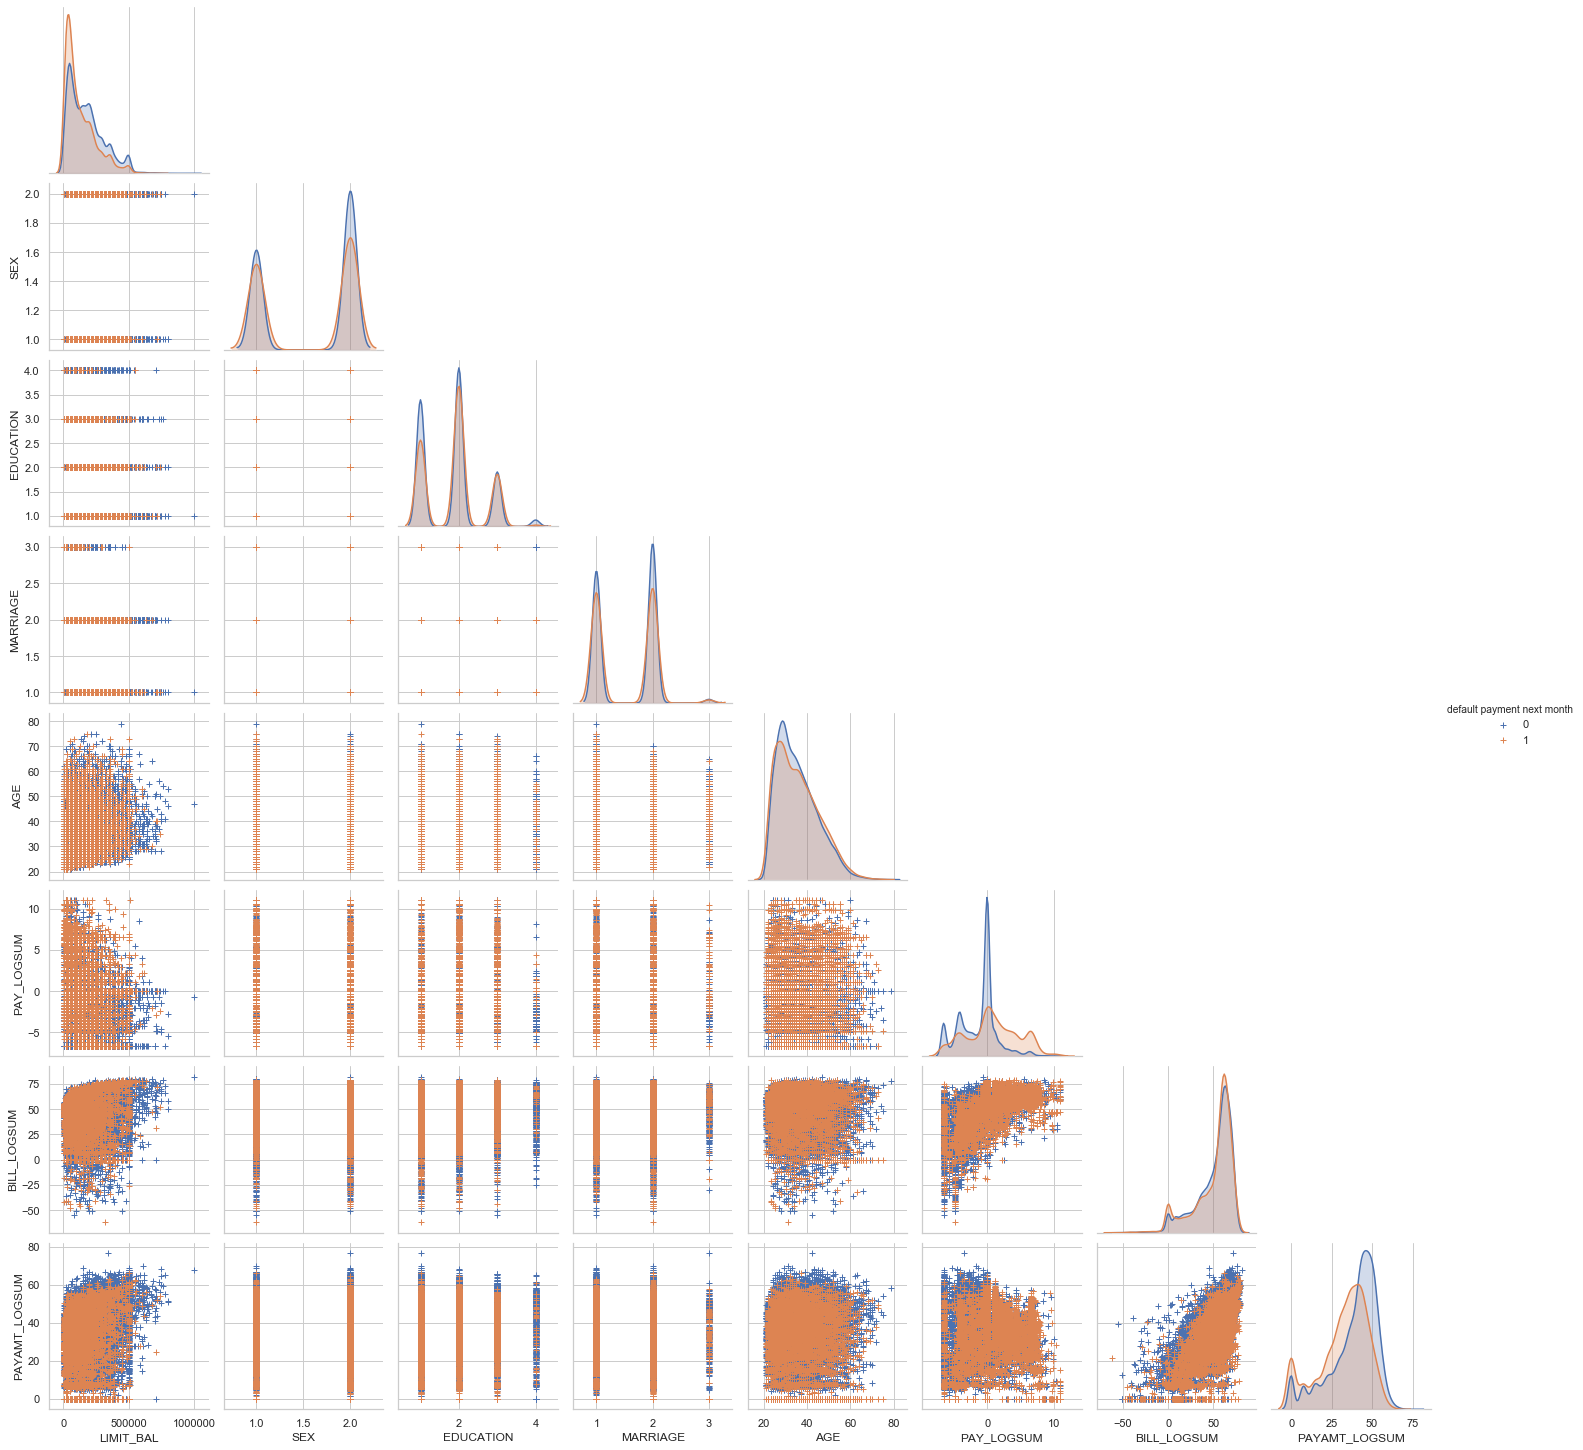

In [34]:
sns.pairplot(scatter_matrix_df, hue="default payment next month", plot_kws=dict(marker="+", linewidth=1), corner=True)

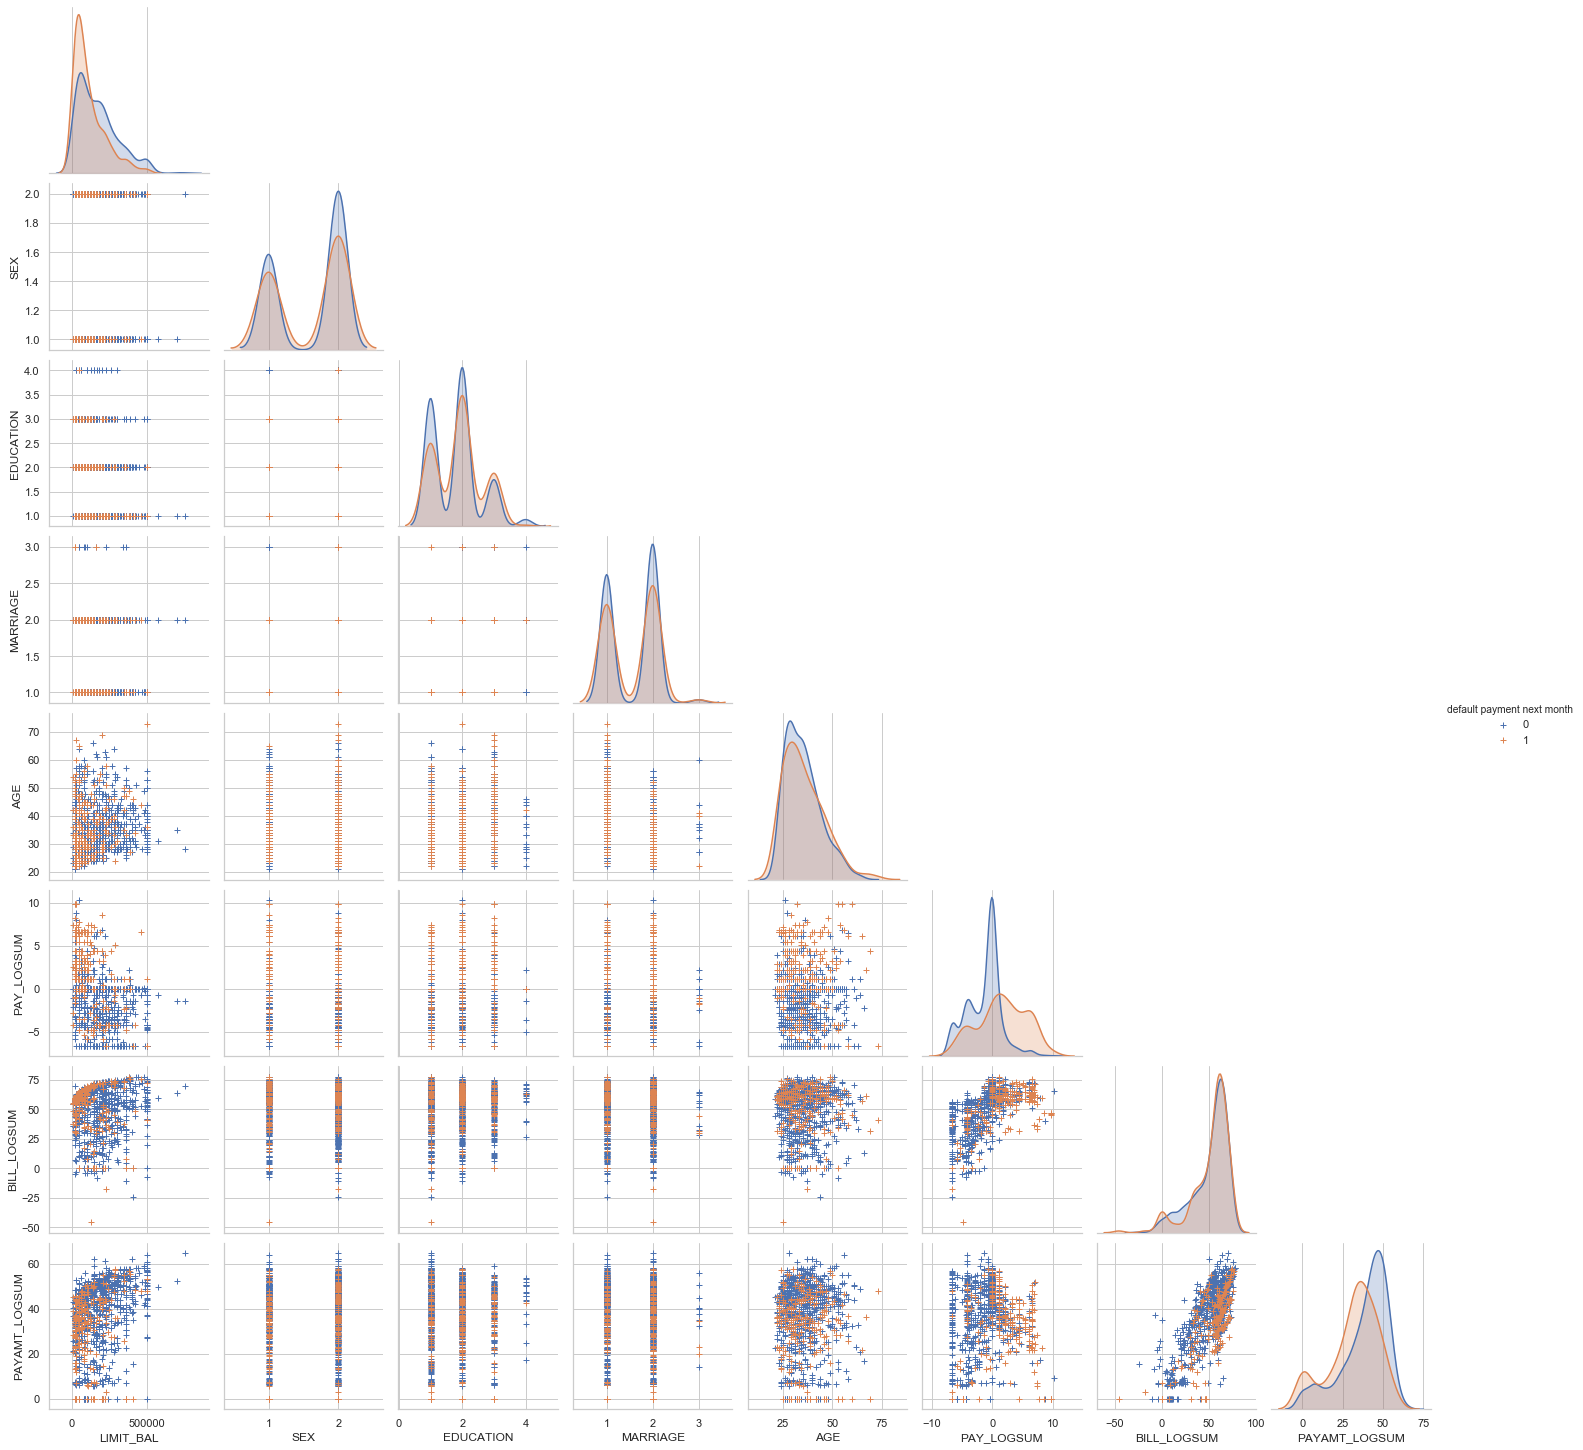

In [35]:
firstcols = df.iloc[:,:6]
firstcols = firstcols.iloc[:,1:]
scatter_matrix_df = pd.concat([firstcols,paydf,billdf,payamtdf,target_tmp], axis=1)
scatter_matrix_df = scatter_matrix_df.sample(frac=1000/30000) # Take a faction of the scatterplot matrix
sns.pairplot(scatter_matrix_df, hue="default payment next month", plot_kws=dict(marker="+", linewidth=1), corner=True)

### Try PCA reduced k-means clustering to find any distinct clusters

We opt to use newdf. We continue this in DataExploration_Unsupervised.ipnyb


